## Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import Env, spaces

## Data definition

In [2]:
antennas = [
    {'id': 'A1', 'x': 0, 'y': 0, 'bandwidth': 100},
    {'id': 'A2', 'x': 100, 'y': 0, 'bandwidth': 80},
    {'id': 'A3', 'x': 50, 'y': 86, 'bandwidth': 120}
]
users = [
    {'id': 'U1', 'x': 10, 'y': 30},
    {'id': 'U2', 'x': 60, 'y': 20},
    {'id': 'U3', 'x': 100, 'y': 60},
    {'id': 'U4', 'x': 20, 'y': 90}
]

In [3]:
df_antennas = pd.DataFrame(antennas)
df_antennas

,id,x,y,bandwidth
0,A1,0,0,100
1,A2,100,0,80
2,A3,50,86,120


In [4]:
df_users = pd.DataFrame(users)
df_users

,id,x,y
0,U1,10,30
1,U2,60,20
2,U3,100,60
3,U4,20,90


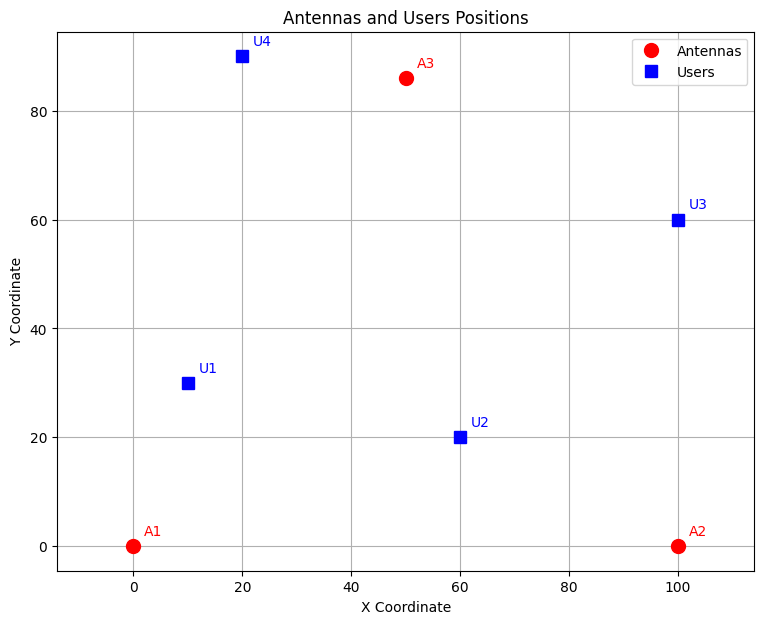

In [5]:
plt.figure(figsize=(9, 7))
plt.plot(df_antennas["x"], df_antennas["y"], 'ro', label='Antennas', markersize=10)
plt.plot(df_users["x"], df_users["y"], 'bs', label='Users', markersize=8)

for i, row in df_antennas.iterrows():
    plt.text(row["x"] + 2, row["y"] + 2, row["id"], color='red', fontsize=10)
for i, row in df_users.iterrows():
    plt.text(row["x"] + 2, row["y"] + 2, row["id"], color='blue', fontsize=10)
    
plt.grid(True)
plt.legend()
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Antennas and Users Positions')
plt.axis('equal')
plt.show()

In [6]:
distance_matrix = np.zeros((len(users), len(antennas)))

for i, user in enumerate(users):
    for j, antenna in enumerate(antennas):
        distance_matrix[i][j] = np.linalg.norm([user['x'] - antenna['x'], user['y'] - antenna['y']])

user_ids = [user['id'] for user in users]
antenna_ids = [antenna['id'] for antenna in antennas]
df_distance = pd.DataFrame(distance_matrix, index=user_ids, columns=antenna_ids)
df_distance

,A1,A2,A3
U1,31.622777,94.868330,68.818602
U2,63.245553,44.721360,66.753277
U3,116.619038,60.000000,56.356011
U4,92.195445,120.415946,30.265492


## Reinforcement Learning

`gym` de OpenAI es una librería de Python que sirve para construir entornos de entrenamiento para aentes de RL. No se entrena el agente como tal, sino que crea el "mundo" donde el agente actúa. Lo que nosotros definimos es:

- Qué puede observar el agente.
- Qué acciones puede tomar.
- Qué recompensa recibe por esas acciones.
- Cuándo termina el episodio.

Un entorno de `gym` siempre tiene 5 funciones:
- __init__(): Inicializa el entorno (usuarios, antenas, etc.).
- reset(): Empieza un nuevo episodio, devuelve el primer estado.
- step(action): Aplica una acción, devuelve: (nuevo estado, recompensa, si terminó, info).
- render(): (Opcional) Muestra visualmente lo que está pasando.
- close(): (Opcional) Libera recursos al final.

### Caso Sencillo: Asignación de usuario a antena única

In [ ]:
class SimpleAntennaEnv(gym.Env):
    def __init__(self):
        super(SimpleAntennaEnv, self).__init__()

        # Datos de antenas
        self.antennas = [
            {'id': 'A0', 'x': 10, 'y': 90, 'bandwidth': 2},
            {'id': 'A1', 'x': 90, 'y': 90, 'bandwidth': 2}
        ]

        self.num_antennas = len(self.antennas)
        self.num_users = 3

        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(self.num_antennas*2,), dtype=np.float32)
        self.action_space = spaces.Discrete(self.num_antennas)

        self.reset()

    def reset(self, seed=None, options=None):
        self.current_user = 0
        self.bandwidth_used = np.zeros(self.num_antennas)

        # Usuarios aleatorios por episodio
        self.users = []
        for i in range(self.num_users):
            self.users.append({
                'id': f'U{i}',
                'x': np.random.uniform(0, 100),
                'y': np.random.uniform(0, 100)
            })

        self.distances = self.compute_distances()
        self.connections = []

        return self._get_observation(), {}


    def compute_distances(self):
        dist_matrix = np.zeros((self.num_users, self.num_antennas))
        for i, user in enumerate(self.users):
            for j, antenna in enumerate(self.antennas):
                dist_matrix[i][j] = np.linalg.norm(
                    [user['x'] - antenna['x'], user['y'] - antenna['y']]
                )
        return dist_matrix

    def _get_observation(self):
        distances = self.distances[self.current_user]
        capacities = np.array([
            self.antennas[i]['bandwidth'] - self.bandwidth_used[i]
            for i in range(self.num_antennas)
        ])
        return np.concatenate([distances, capacities]).astype(np.float32)

    def step(self, action):
        user_idx = self.current_user
        antenna_idx = action
        distance = self.distances[user_idx][antenna_idx]

        if distance <= 50:
            if self.bandwidth_used[antenna_idx] < self.antennas[antenna_idx]['bandwidth']:
                reward = 1
                self.bandwidth_used[antenna_idx] += 1
            else:
                reward = 0  # dentro de rango, pero saturada
        else:
            reward = -1  # fuera de rango

        self.connections.append((user_idx, antenna_idx))
        self.current_user += 1
        terminated = self.current_user >= self.num_users
        truncated = False

        if terminated:
            obs = np.zeros(self.observation_space.shape, dtype=np.float32)
        else:
            obs = self._get_observation()

        return obs, reward, terminated, truncated, {}

    def render(self, mode='human'):
        plt.figure(figsize=(8, 6))

        for antenna in self.antennas:
            plt.plot(antenna['x'], antenna['y'], 'ro', markersize=10)
            plt.text(antenna['x'] + 1, antenna['y'] + 1, antenna['id'], color='red')

        for user in self.users:
            plt.plot(user['x'], user['y'], 'bs', markersize=8)
            plt.text(user['x'] + 1, user['y'] + 1, user['id'], color='blue')

        for user_idx, antenna_idx in self.connections:
            user = self.users[user_idx]
            antenna = self.antennas[antenna_idx]
            plt.plot(
                [user['x'], antenna['x']],
                [user['y'], antenna['y']],
                'g--'
            )

        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('Antennas, Users and Connections')
        plt.grid(True)
        plt.axis('equal')
        plt.show()

In [91]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env

# Verificamos que el entorno esté bien implementado
check_env(SimpleAntennaEnv())

# Creamos el entorno
env = SimpleAntennaEnv()

# Creamos el modelo PPO
model = PPO("MlpPolicy", env, verbose=1)

# Entrenamos el modelo
model.learn(total_timesteps=10000)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Users\algar\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -1.2     |
| time/              |          |
|    fps             | 344      |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 3           |
|    ep_rew_mean          | -0.73       |
| time/                   |             |
|    fps                  | 243         |
|    iterations           | 2           |
|    time_elapsed         | 16          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.018823918 |
|    clip_fraction        | 0.472       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.675      |
|    explained_variance   | -0.0883     |
|    learning_rate        | 0.

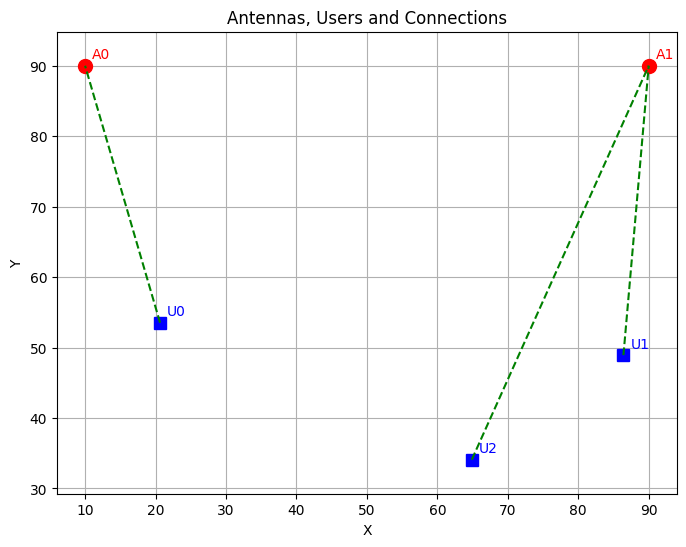

Agent total reward: 1


In [97]:
obs, _ = env.reset()
done = False
total_reward = 0

while not done:
    action, _ = model.predict(obs)
    obs, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    total_reward += reward

env.render()
plt.show()

print(f"Agent total reward: {total_reward}")

### Caso Complejo: Asignación de usuario a varias antenas

`self.observation_space`: La estructura del estado que el agente ve en cada paso. Es la información que se le da para que decida qué acción tomar. En nuestro caso:

```
self.observation_space = spaces.Box(
    low=0.0,
    high=np.inf,
    shape=(self.num_antennas * 2,),
    dtype=np.float32
)
```

Le estamos diciendo al agente que va a recibir un vector de tamaño 2xnum_antennas. Para cada antena, el vector tiene:
- Distancia entre el usuario actual y esa antena.
- Capacidad restante (Mbps disponibles) en esa antena.

Ejemplo:
```
[
 dist_a0, dist_a1, dist_a2, dist_a3, dist_a4,
 cap_a0,  cap_a1,  cap_a2,  cap_a3,  cap_a4
]
```


In [168]:
class MultiAntennaEnv(gym.Env):
    def __init__(self):
        """
        Initialize the environment with:
        - 5 fixed antennas, each with 1000 Mbps total capacity
        - A fixed number of users (default: 3)
        - Observation and action space definitions
        """
        super(MultiAntennaEnv, self).__init__()

        # Fixed antennas, each with 1000 Mbps total capacity
        self.antennas = [
            {'id': 'A0', 'x': 10,  'y': 90, 'bandwidth': 1000.0},
            {'id': 'A1', 'x': 90,  'y': 90, 'bandwidth': 1000.0},
            {'id': 'A2', 'x': 50,  'y': 50, 'bandwidth': 1000.0},
            {'id': 'A3', 'x': 20,  'y': 20, 'bandwidth': 1000.0},
            {'id': 'A4', 'x': 80,  'y': 20, 'bandwidth': 1000.0},
        ]

        self.num_antennas = len(self.antennas)
        self.num_users = 3
        self.max_distance = 50.0
        self.user_demand = 50.0  # Mbps required per user

        # Observation: distances to antennas + remaining capacity per antenna
        self.observation_space = spaces.Box(
            low=0.0, high=np.inf,
            shape=(self.num_antennas * 2,),
            dtype=np.float32
        )

        # Action: fraction of the user's demand assigned to each antenna
        self.action_space = spaces.Box(
            low=0.0, high=1.0,
            shape=(self.num_antennas,),
            dtype=np.float32
        )

        self.reset()

    def reset(self, seed=None, options=None):
        """
        Reset the environment at the beginning of an episode:
        - Set bandwidth usage to zero
        - Generate new random user positions
        - Precompute distances
        - Return the initial observation
        """
        self.current_user = 0
        self.bandwidth_used = np.zeros(self.num_antennas)

        # Generate random users within a 100x100 area
        self.users = []
        for i in range(self.num_users):
            self.users.append({
                'id': f'U{i}',
                'x': np.random.uniform(0, 100),
                'y': np.random.uniform(0, 100)
            })

        self.distances = self.compute_distances()
        self.connections = []
        return self._get_observation(), {}

    def compute_distances(self):
        """
        Compute and return a matrix of Euclidean distances between
        each user and each antenna (shape: num_users × num_antennas).
        """
        dist_matrix = np.zeros((self.num_users, self.num_antennas))
        for i, user in enumerate(self.users):
            for j, antenna in enumerate(self.antennas):
                dist_matrix[i][j] = np.linalg.norm(
                    [user['x'] - antenna['x'], user['y'] - antenna['y']]
                )
        return dist_matrix

    def _get_observation(self):
        """
        Return the current observation:
        - Distances from current user to all antennas
        - Remaining bandwidth of each antenna
        """
        distances = self.distances[self.current_user]
        capacities = np.array([
            self.antennas[i]['bandwidth'] - self.bandwidth_used[i]
            for i in range(self.num_antennas)
        ])
        return np.concatenate([distances, capacities]).astype(np.float32)

    def step(self, action):
        """
        Take a step in the environment:
        - The agent proposes a fractional assignment to each antenna
        - We compute how much bandwidth is actually assigned (respecting distance and capacity limits)
        - Reward is based on whether the user's demand is fully, partially, or not met
        - Move to the next user
        """
        action = np.clip(action, 0, 1)  # seguridad

        # Normalize if sum of fractions exceeds 1.0
        total_fraction = np.sum(action)
        if total_fraction > 1.0:
            action = action / total_fraction
            
        total_assigned = 0.0
        valid_assignments = np.zeros(self.num_antennas)

        for j in range(self.num_antennas):
            dist = self.distances[self.current_user][j]
            assign_mbps = action[j] * self.user_demand

            if dist <= self.max_distance:
                if self.bandwidth_used[j] + assign_mbps <= self.antennas[j]['bandwidth']:
                    valid_assignments[j] = assign_mbps
                    self.bandwidth_used[j] += assign_mbps
                    total_assigned += assign_mbps

        self.connections.append((self.current_user, valid_assignments.copy()))

        # Recompensa basada en asignación total válida
        if total_assigned >= self.user_demand:
            reward = 1.0
        elif total_assigned > 0:
            reward = 0.5
        else:
            reward = -1.0

        self.current_user += 1
        terminated = self.current_user >= self.num_users
        truncated = False

        if terminated:
            obs = np.zeros(self.observation_space.shape, dtype=np.float32)
        else:
            obs = self._get_observation()

        return obs, reward, terminated, truncated, {}

    def render(self, mode='human'):
        """
        Display a 2D plot showing:
        - Red circles: antennas with usage/remaining bandwidth
        - Blue squares: users with total Mbps received
        - Green dashed lines: links representing partial connections
        """
        fig, ax = plt.subplots(figsize=(9, 7))

        for i, antenna in enumerate(self.antennas):
            used = self.bandwidth_used[i]
            total = antenna['bandwidth']
            remaining = total - used

            ax.plot(antenna['x'], antenna['y'], 'ro', markersize=10)
            ax.text(
                antenna['x'] + 1,
                antenna['y'] + 1,
                f"{antenna['id']}\nused: {used:.0f} / left: {remaining:.0f} Mbps",
                color='red',
                fontsize=9
            )

        for user_idx, user in enumerate(self.users):
            ax.plot(user['x'], user['y'], 'bs', markersize=8)

            # Sum of assigned Mbps from all antennas to this user
            if user_idx < len(self.connections):
                assignment = self.connections[user_idx][1]
                received = np.sum(assignment)
                label = f"{user['id']}\nreceived: {received:.1f} Mbps"
            else:
                label = f"{user['id']}"

            ax.text(user['x'] + 1, user['y'] + 1, label, color='blue', fontsize=9)

        for user_idx, assignment in self.connections:
            user = self.users[user_idx]
            for j in range(self.num_antennas):
                if assignment[j] > 0:
                    antenna = self.antennas[j]
                    ax.plot([user['x'], antenna['x']], [user['y'], antenna['y']], 'g--')

        ax.set_xlabel('X coordinate')
        ax.set_ylabel('Y coordinate')
        ax.set_title('User connections and antenna usage (in Mbps)')
        ax.grid(True)
        ax.set_aspect('equal')
        plt.show()

In [169]:
# Instantiate the environment
env = MultiAntennaEnv()
check_env(env)

# Create the PPO model
model = PPO("MlpPolicy", env, verbose=1)

# Train
model.learn(total_timesteps=20000)

c:\Users\algar\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\env_checker.py:462: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(
c:\Users\algar\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | 0.5      |
| time/              |          |
|    fps             | 565      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 3           |
|    ep_rew_mean          | 0.56        |
| time/                   |             |
|    fps                  | 461         |
|    iterations           | 2           |
|    time_elapsed         | 8           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.019402843 |
|    clip_fraction        | 0.272       |
|    clip_range           | 0.2         |
|    entropy_loss  

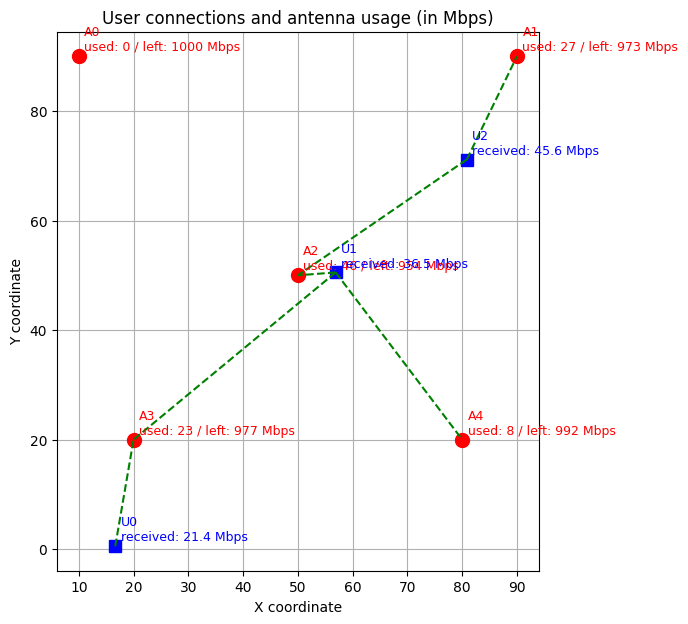


Total reward: 1.5


In [173]:
obs, _ = env.reset()
done = False
total_reward = 0

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    total_reward += reward

env.render()
print(f"\nTotal reward: {total_reward}")